# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

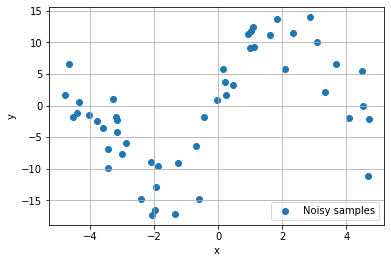

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

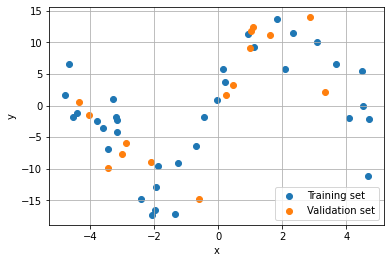

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

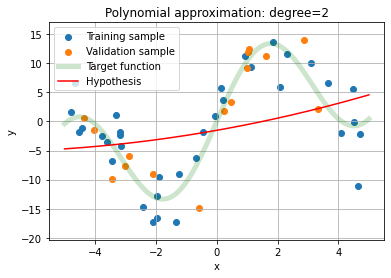

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

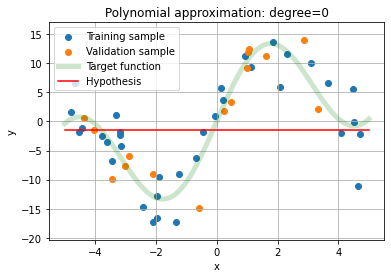

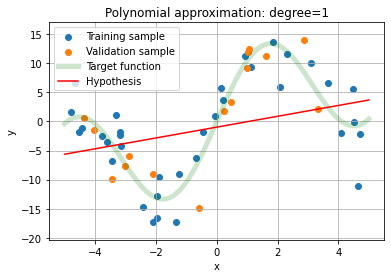

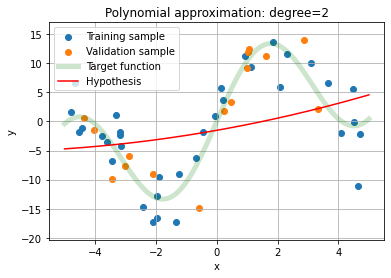

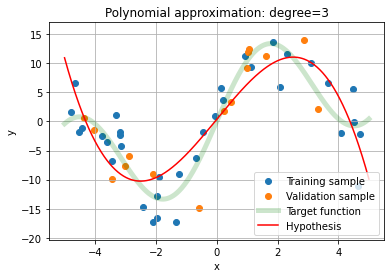

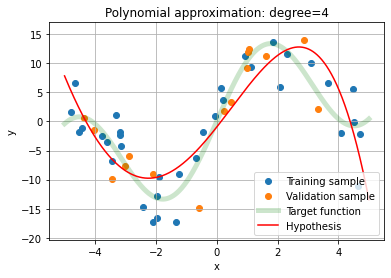

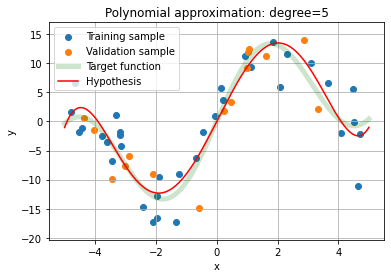

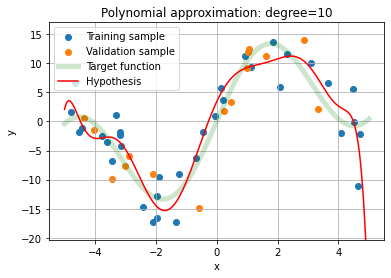

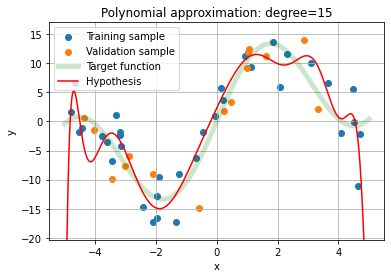

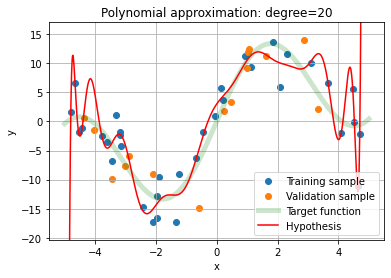

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

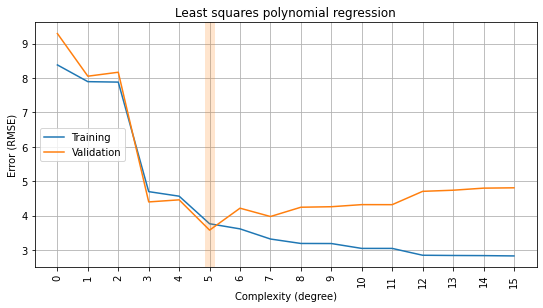

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

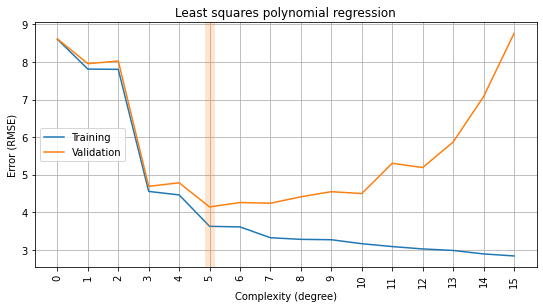

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

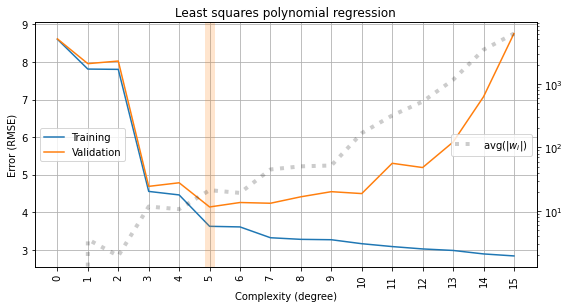

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

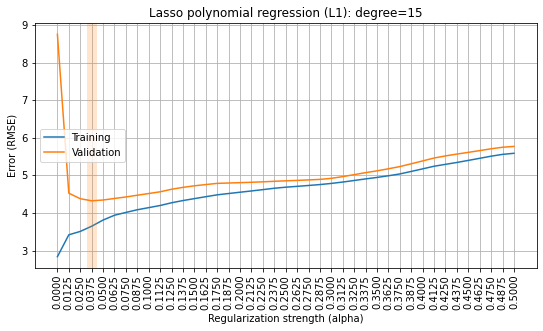

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

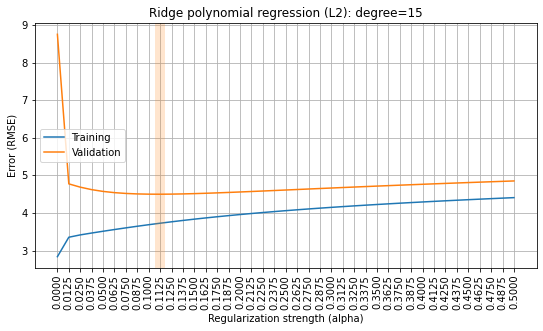

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
data_full = df = pd.DataFrame(data=np.c_[data['data'], data['target']], columns=data['feature_names']+['target'])
data_full.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [22]:
print('shape: ', data_full.shape)
print(data_full.info())

shape:  (442, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
None


In [23]:
round(data_full.describe(include="all"),5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000
mean,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,152.13348
std,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,77.09300
min,-0.10723,-0.04464,-0.09028,-0.11240,-0.12678,-0.11561,-0.10231,-0.07639,-0.12610,-0.13777,25.00000
25%,-0.03730,-0.04464,-0.03423,-0.03666,-0.03425,-0.03036,-0.03512,-0.03949,-0.03325,-0.03318,87.00000
50%,0.00538,-0.04464,-0.00728,-0.00567,-0.00432,-0.00382,-0.00658,-0.00259,-0.00195,-0.00108,140.50000
75%,0.03808,0.05068,0.03125,0.03564,0.02836,0.02984,0.02931,0.03431,0.03243,0.02792,211.50000
max,0.11073,0.05068,0.17056,0.13204,0.15391,0.19879,0.18118,0.18523,0.13360,0.13561,346.00000


In [24]:
print(data_full.groupby('target').size())

target
25.0     1
31.0     1
37.0     1
39.0     2
40.0     1
        ..
321.0    1
332.0    1
336.0    1
341.0    1
346.0    1
Length: 214, dtype: int64


In [25]:
print('\nUnique')
data_full.apply(lambda x: x.nunique())


Unique


age        58
sex         2
bmi       163
bp        100
s1        141
s2        302
s3         63
s4         66
s5        184
s6         56
target    214
dtype: int64

Данные не содержат пропущенные значения. Посмотрим на каждый параметр в отдельности и на их корреляцию.

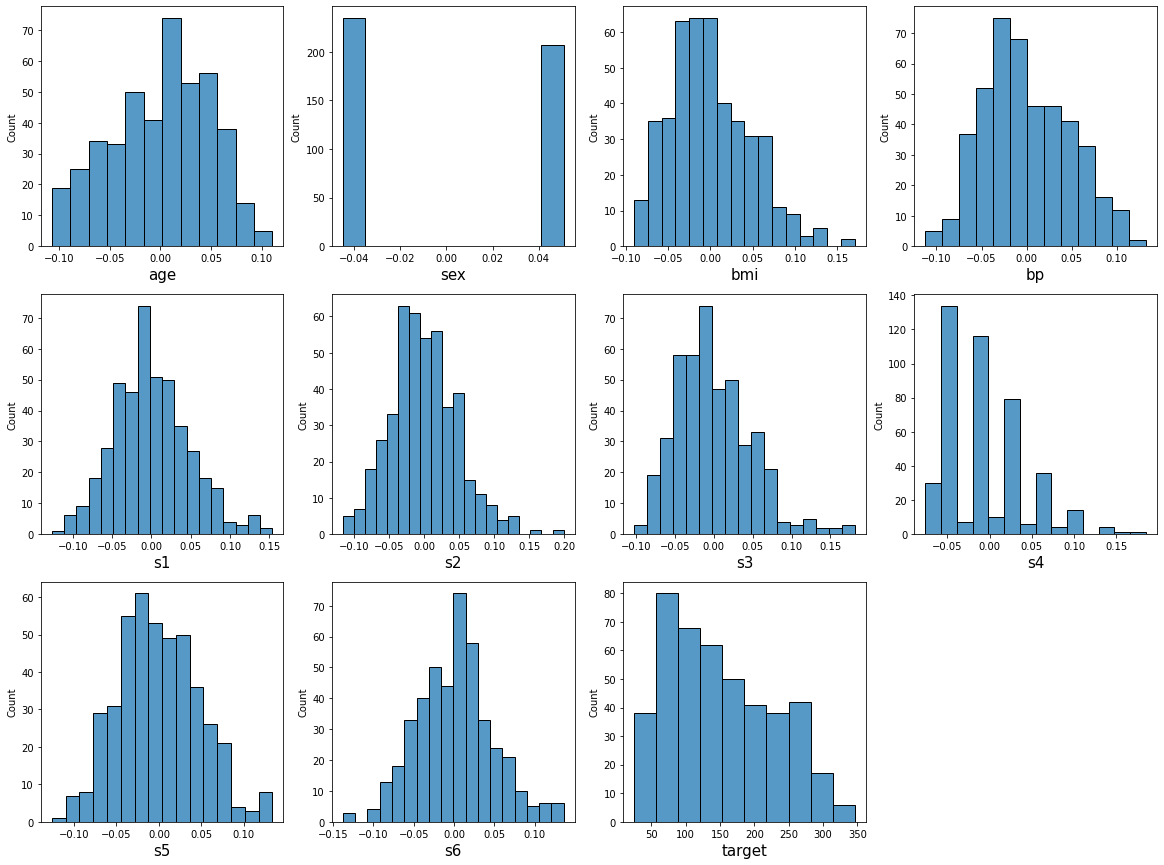

In [26]:
# Построим гистограммы параметров
plt.figure(figsize = (20, 15))
plot_num = 1

for column in data_full:
    if plot_num >= 0:
        ax = plt.subplot(3, 4, plot_num)
        sns.histplot(data_full[column])
        plt.xlabel(column, fontsize = 15)
    plot_num += 1
plt.show()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.00,0.17,0.19,0.34,0.26,0.22,-0.08,0.20,0.27,0.30,0.19
sex,0.17,1.00,0.09,0.24,0.04,0.14,-0.38,0.33,0.15,0.21,0.04
bmi,0.19,0.09,1.00,0.40,0.25,0.26,-0.37,0.41,0.45,0.39,0.59
bp,0.34,0.24,0.40,1.00,0.24,0.19,-0.18,0.26,0.39,0.39,0.44
s1,0.26,0.04,0.25,0.24,1.00,0.90,0.05,0.54,0.52,0.33,0.21
s2,0.22,0.14,0.26,0.19,0.90,1.00,-0.20,0.66,0.32,0.29,0.17
s3,-0.08,-0.38,-0.37,-0.18,0.05,-0.20,1.00,-0.74,-0.40,-0.27,-0.39
s4,0.20,0.33,0.41,0.26,0.54,0.66,-0.74,1.00,0.62,0.42,0.43
s5,0.27,0.15,0.45,0.39,0.52,0.32,-0.40,0.62,1.00,0.46,0.57
s6,0.30,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1.00,0.38


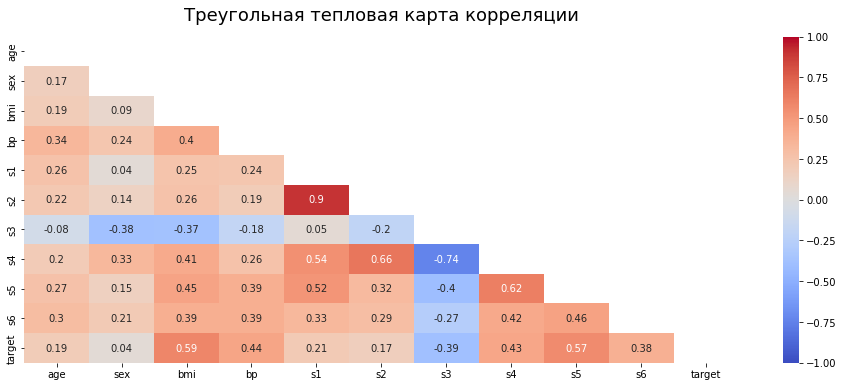

In [27]:
#Построим корреляционную матрицу и тепловую карту, чтобы выяснить, какие параметры имеют большую корреляцию
correlation_matrix = data_full.corr().round(2)
display(correlation_matrix)
plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool_)) 
heatmap = sns.heatmap(correlation_matrix, mask=mask, vmin=-1, vmax=1, annot = True, cmap='coolwarm') 
heatmap.set_title('Треугольная тепловая карта корреляции', fontdict={'fontsize':18}, pad=16);

Лучше всего корреляция целевой функции с  bmi body mass index  (индексом массы тела) и s5 ltg, possibly log of serum triglycerides level (уровень триглицеридов) 

Разделим данные на тренировочный и тестовый датасет. В последующем исследовательском анализе будет использоваться только набор тренировочных данных. Это способ сымитировать реальную ситуацию, когда прогнозы выполняются на неизвестной цели, и мы не хотим, чтобы наш анализ и решения были предвзяты из-за нашего знания тестовых данных.

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

In [29]:
y_train.to_numpy()


array([[208.],
       [261.],
       [179.],
       [258.],
       [262.],
       [ 51.],
       [237.],
       [ 71.],
       [139.],
       [268.],
       [ 69.],
       [317.],
       [249.],
       [154.],
       [192.],
       [116.],
       [ 81.],
       [122.],
       [259.],
       [191.],
       [292.],
       [ 55.],
       [107.],
       [210.],
       [ 91.],
       [253.],
       [ 85.],
       [252.],
       [ 59.],
       [ 78.],
       [200.],
       [ 78.],
       [245.],
       [175.],
       [ 42.],
       [127.],
       [ 53.],
       [ 94.],
       [104.],
       [199.],
       [265.],
       [281.],
       [248.],
       [257.],
       [215.],
       [303.],
       [170.],
       [ 59.],
       [277.],
       [209.],
       [138.],
       [198.],
       [124.],
       [ 96.],
       [288.],
       [225.],
       [265.],
       [101.],
       [ 55.],
       [198.],
       [ 51.],
       [252.],
       [ 64.],
       [220.],
       [131.],
       [212.],
       [14

Рассмотрим распределения переменных и попарные отношения между ними. 

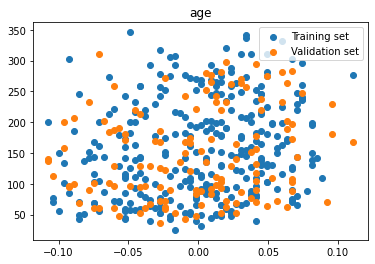

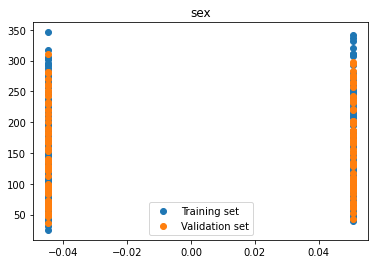

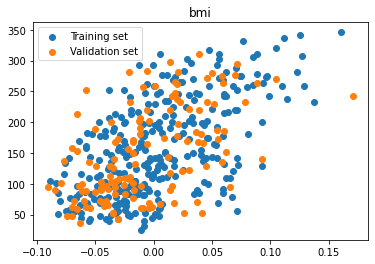

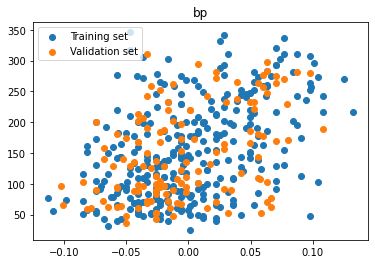

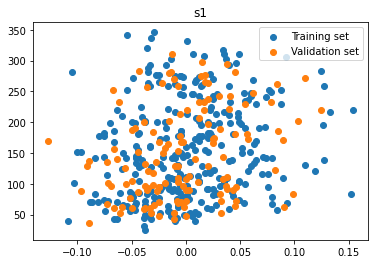

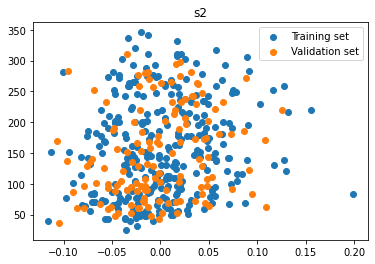

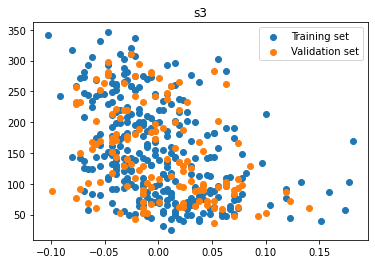

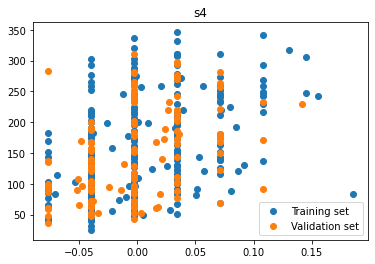

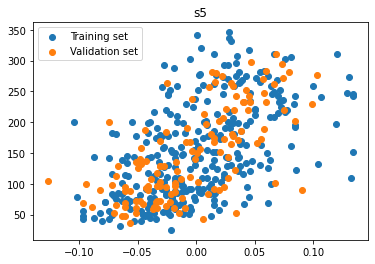

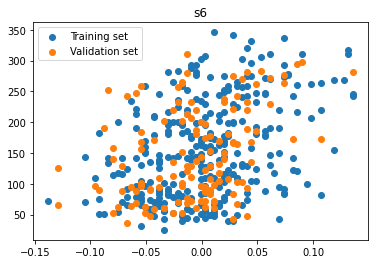

In [30]:
columns = data['feature_names']
for i in range(10):
    plt.scatter(X_train[columns[i]], y_train, label='Training set')
    plt.scatter(X_valid[columns[i]], y_valid, label='Validation set')
    plt.title(columns[i])
    plt.legend()
    plt.show()
    i+=1

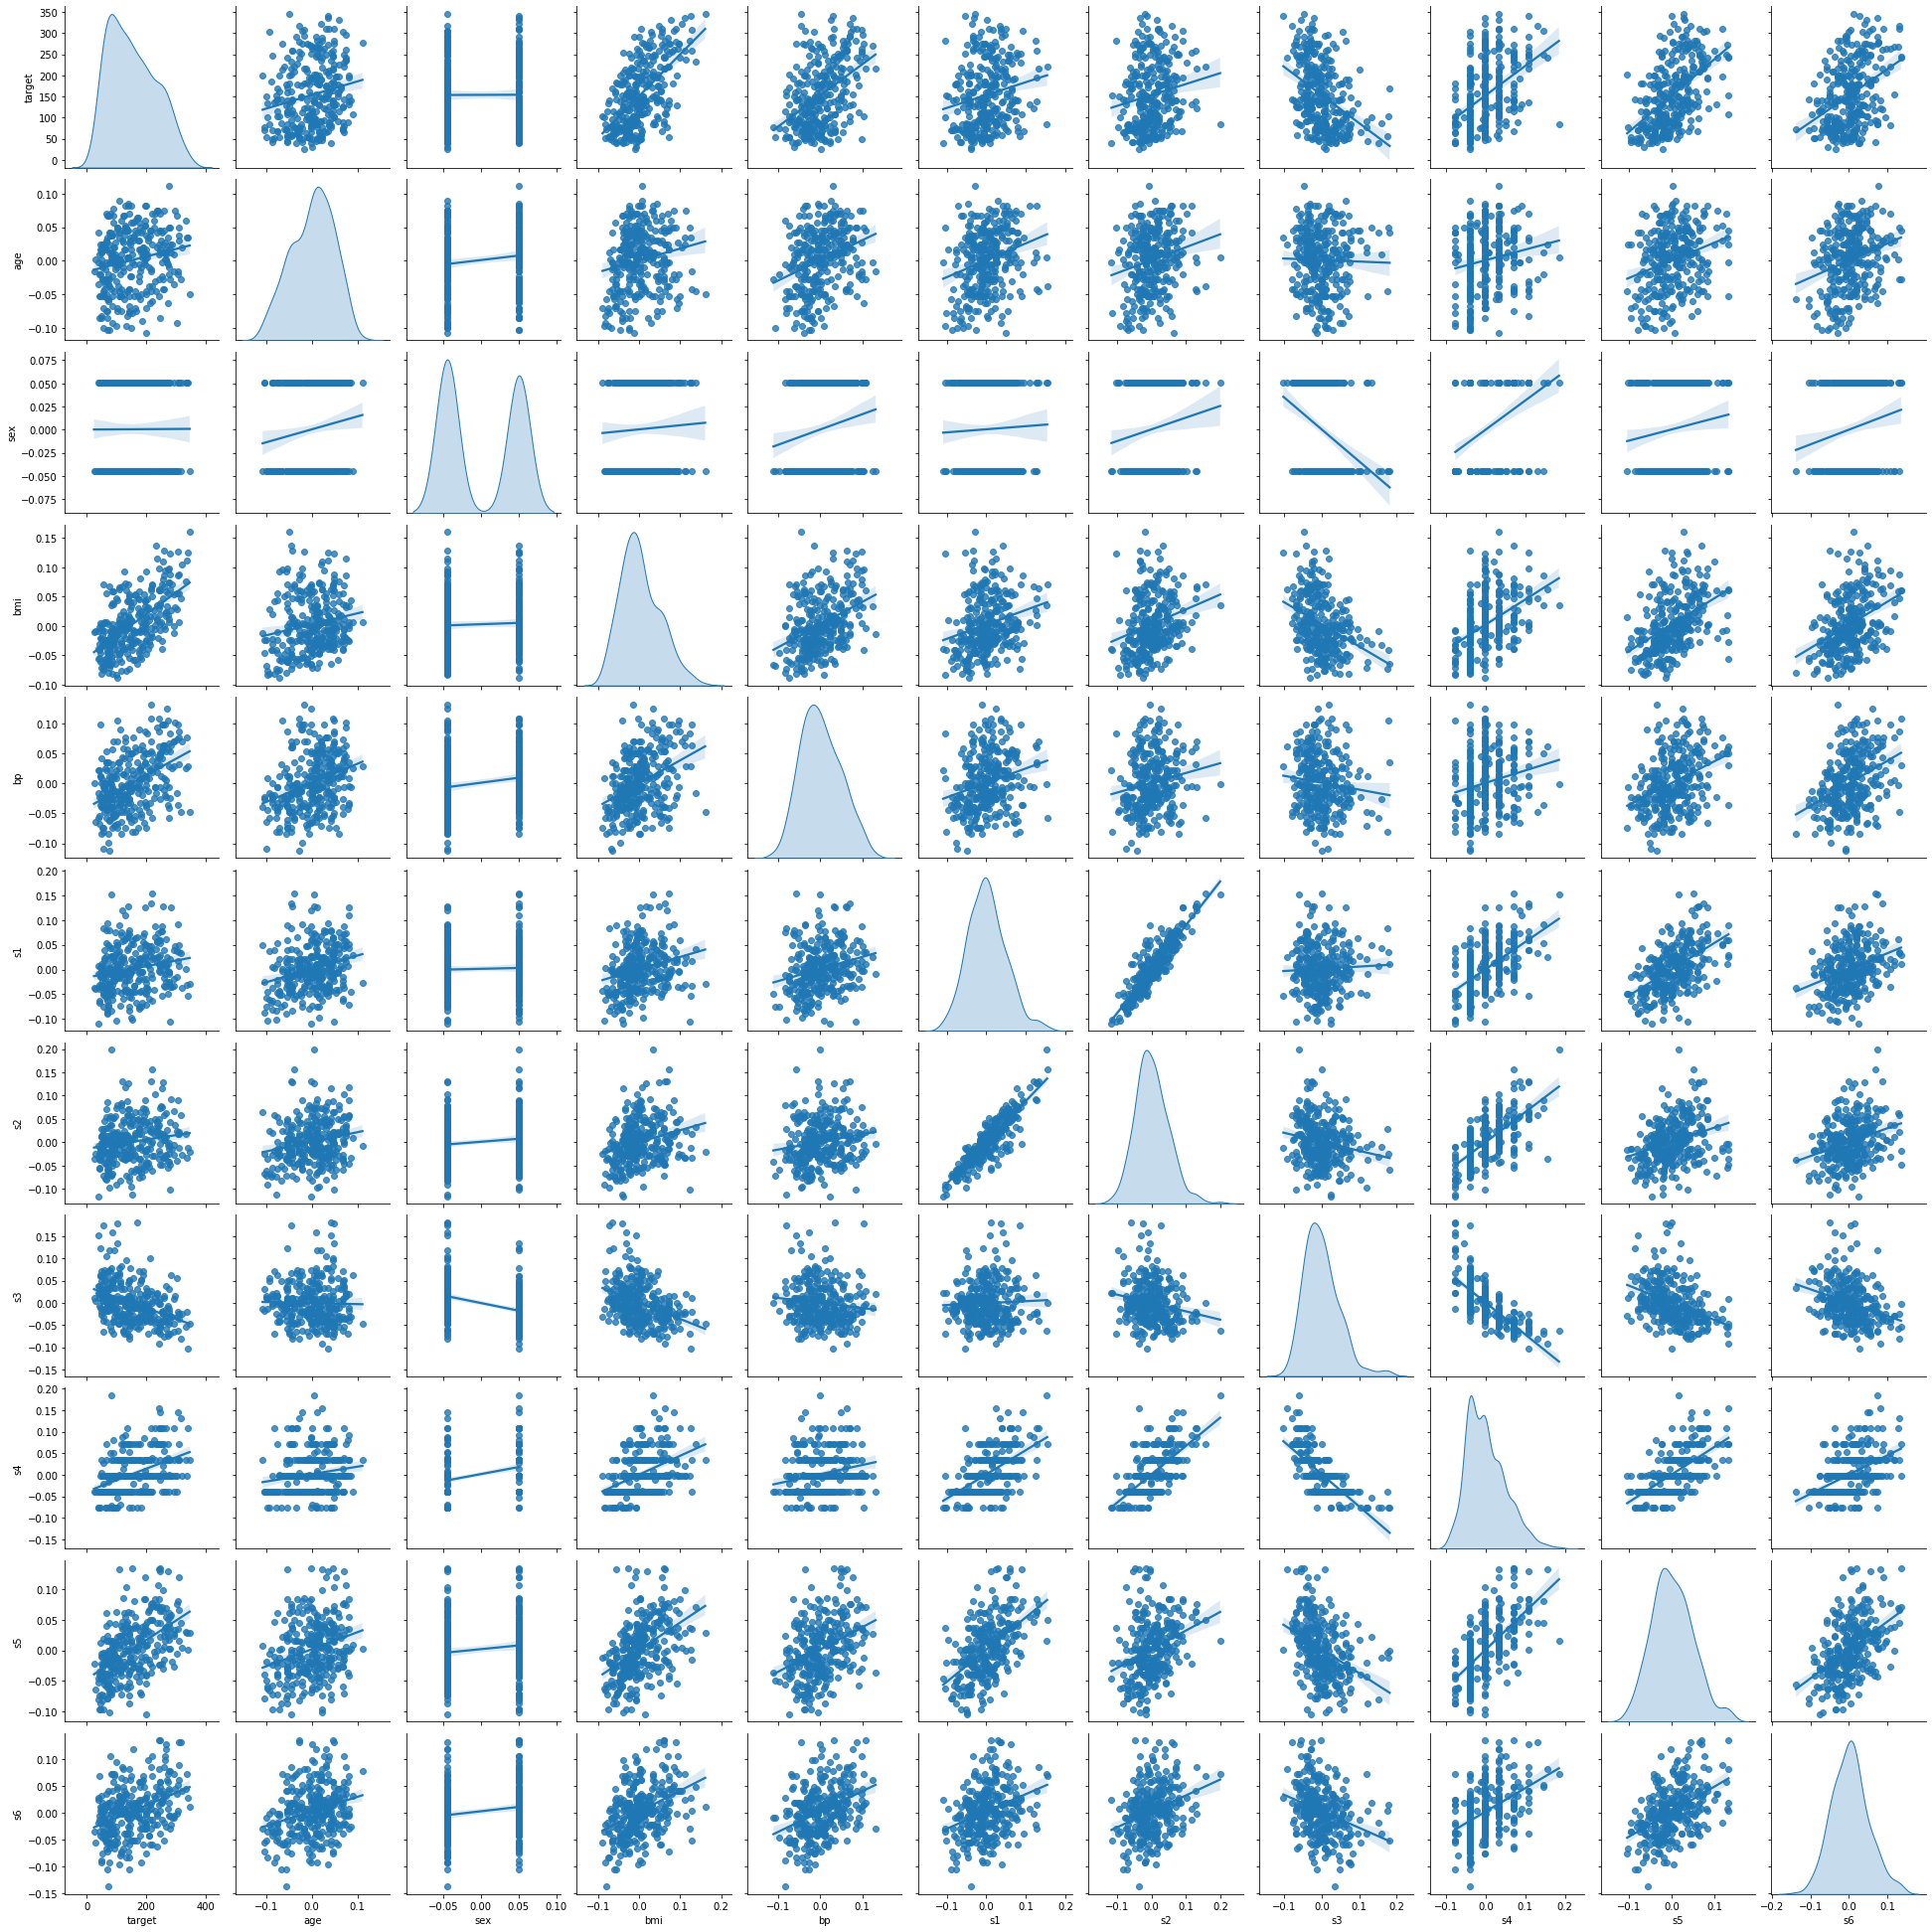

In [31]:
training_data = X_train.copy()
training_data.insert(0, "target", y_train)
sns.pairplot(training_data, kind="reg", diag_kind="kde")

Заполним модель

In [32]:
model = LinearRegression(fit_intercept=True)
model_train = model.fit(X_train, y_train);
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: [151.00818273]
model_coef: [[  29.25034582 -261.70768053  546.29737263  388.40077257 -901.95338706
   506.761149    121.14845948  288.02932495  659.27133846   41.37536901]]


In [33]:
model_preds = model.predict(X_valid)
model_preds

array([[138.47032272],
       [181.10311796],
       [125.34650402],
       [292.75409394],
       [123.88080069],
       [ 91.89920521],
       [257.26623571],
       [177.76309357],
       [ 84.98399508],
       [109.15734248],
       [ 94.4860807 ],
       [166.13170425],
       [ 57.40863723],
       [206.13846128],
       [ 97.78386268],
       [131.0064874 ],
       [214.29968996],
       [252.53124994],
       [199.6645535 ],
       [219.49967665],
       [203.2365464 ],
       [ 88.00667238],
       [ 70.65206201],
       [186.92065774],
       [155.81290675],
       [162.80795787],
       [191.93403891],
       [184.72672694],
       [ 46.62855775],
       [108.26601337],
       [178.14954273],
       [ 91.35193917],
       [127.72256442],
       [184.04456013],
       [172.23860522],
       [189.51563882],
       [121.83424016],
       [117.75704799],
       [145.68144979],
       [ 58.57463632],
       [ 72.55651144],
       [107.28029907],
       [166.15444516],
       [153

In [34]:
make_model(degree=10).fit(X_train, y_train)['reg'].coef_

array([[ 4.82428604, -2.34130852,  3.32311218, ..., -0.02414414,
         0.09239547,  0.11789436]])

In [35]:
y_valid.to_numpy()

array([[219.],
       [ 70.],
       [202.],
       [230.],
       [111.],
       [ 84.],
       [242.],
       [272.],
       [ 94.],
       [ 96.],
       [ 94.],
       [252.],
       [ 99.],
       [297.],
       [135.],
       [ 67.],
       [295.],
       [264.],
       [170.],
       [275.],
       [310.],
       [ 64.],
       [128.],
       [232.],
       [129.],
       [118.],
       [263.],
       [ 77.],
       [ 48.],
       [107.],
       [140.],
       [113.],
       [ 90.],
       [164.],
       [180.],
       [233.],
       [ 42.],
       [ 84.],
       [172.],
       [ 63.],
       [ 48.],
       [108.],
       [156.],
       [168.],
       [ 90.],
       [ 52.],
       [200.],
       [ 87.],
       [ 90.],
       [258.],
       [136.],
       [158.],
       [ 69.],
       [ 72.],
       [171.],
       [ 95.],
       [ 72.],
       [151.],
       [168.],
       [ 60.],
       [122.],
       [ 52.],
       [187.],
       [102.],
       [214.],
       [248.],
       [18

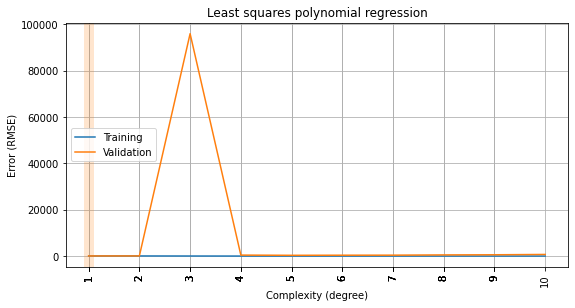

In [36]:
rmse_train, rmse_valid = [], []
DEGREES = np.linspace(1, 10, dtype=int)
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

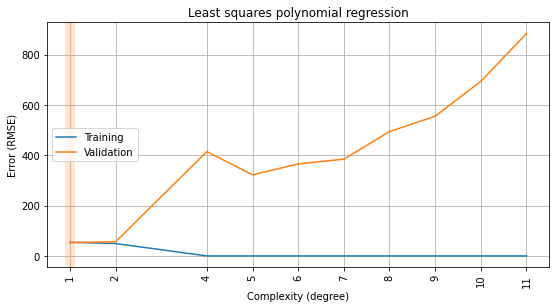

In [37]:
rmse_train, rmse_valid = [], []

DEGREES = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

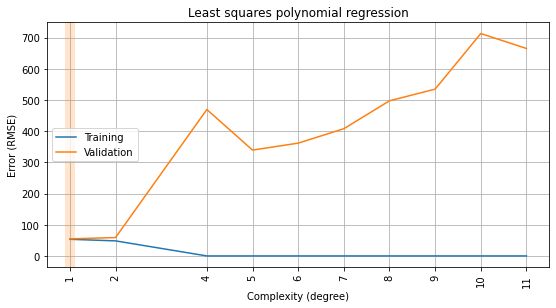

In [38]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

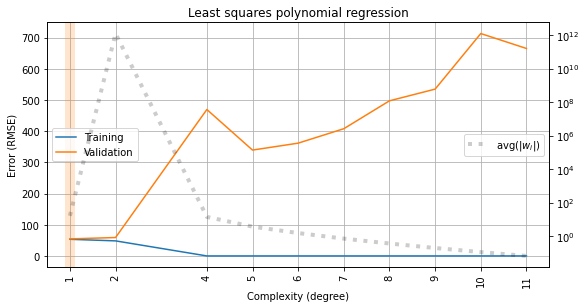

In [39]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

In [40]:
DEGREES[np.argmin(rmse_valid)]

1

Наблюдаем следующее:
1 - степень, наиболее подходящая для данной модели. С большими степенями модели происходит переобучение.
Недообучение (степень <1): модель не может правильно подобрать данные. 

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

В основе L1-регуляризации лежит достаточно простая идея. Как и в случае L2-регуляризации, мы просто добавляем штраф к первоначальной функции затрат. Подобно тому, как в L2-регуляризации мы используем L2-нормирование для поправки весовых коэффициентов, в L1-регуляризации мы используем специальное L1-нормирование. L2-регуляризация называется также регрессией Риджа, а L1-регуляризация – лассо-регрессией.


#### L1

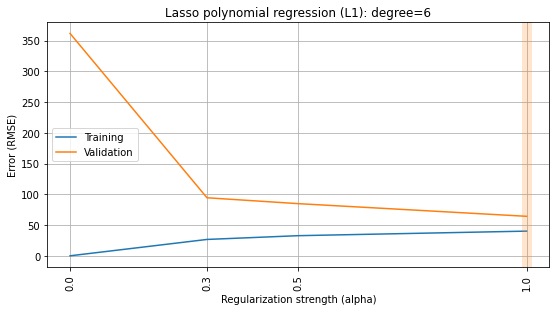

In [41]:
rmse_train, rmse_valid = [], []
ALPHAS = np.linspace(0, 0.5, 1 + 40)
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=6, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=6')

In [42]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso

lasso_regr = Lasso(alpha=0.1) # alpha — величина регуляризации

# обучение
lasso_regr.fit(X_train, y_train)

# предсказание результата
print(lasso_regr.predict(X_valid))

# вывод точности предсказания
print(lasso_regr.score(X_valid, y_valid))

[149.26536651 179.15765158 145.41586527 270.86348326 127.62848306
 103.17456158 260.14831962 197.71724402  84.69784804 125.34825213
 103.76519341 151.39511046  71.1787177  203.43864854 101.50079694
 133.50645712 217.09370711 241.13225885 193.17760144 212.70863589
 201.86625499  93.32815994  71.18534083 189.96453244 161.00709861
 166.38441962 195.15297583 174.00244834  52.29074443 120.86693988
 182.72566968  99.40085095 135.88426716 177.23850811 170.26656762
 206.7999885  125.55850293 124.05411747 143.76908733  61.92093656
  73.73131483 110.52159177 160.03784014 140.13187857 166.17866596
  72.5290964   83.54963986  93.29377325  61.31395844 157.08189342
 155.91259636  74.21115203 121.70386634 105.39668429 177.48080678
 165.11159391  97.43626221 205.66047716 120.22963608  57.86441825
 186.29047342 196.75433246 146.07657495 110.03172377 123.10097851
 204.90709777 173.76318792 162.92080084 115.94671022 144.71405311
 178.68415189 195.97806453 219.74443975 145.65046322  80.80614126
 152.23400

C:\Users\НР\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'Model predictions')

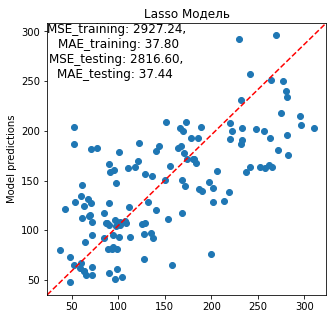

In [43]:
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LassoCV

model_L = LassoCV()
model_L.fit(X_train, y_train)
y_pred = model_L.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mae = median_absolute_error(y_train, y_pred)
text = f"MSE_training: {mse:.2f}, \nMAE_training: {mae:.2f}"
y_pred = model_L.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mae = median_absolute_error(y_valid, y_pred)
text += f"\nMSE_testing: {mse:.2f}, \nMAE_testing: {mae:.2f}  "
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_valid, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(100, 280, text, horizontalalignment='center',
     verticalalignment='center', fontsize=12)
plt.title("Lasso Модель")
plt.ylabel("Model predictions")

Лассо-регрессия сходна с гребневой, за исключением того, что коэффициенты регрессии могут равняться нулю (часть признаков при этом исключается из модели).

#### L2

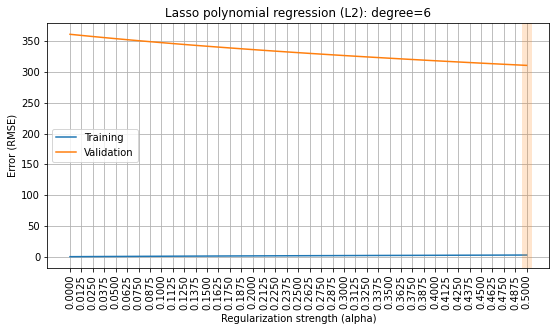

In [45]:
rmse_train, rmse_valid = [], []
ALPHAS = np.linspace(0, 0.5, 1 + 40)
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=6, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L2): degree=6')

In [46]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

ridge_regr = Ridge(alpha=0.1)  # alpha — величина регуляризации

# обучение
ridge_regr.fit(X_train, y_train)

# предсказание результата
print(ridge_regr.predict(X_valid))

# вывод точности предсказания
print(ridge_regr.score(X_valid, y_valid))

[[143.16915624]
 [178.63182643]
 [136.20702629]
 [285.68004568]
 [126.25485547]
 [100.18114848]
 [249.30632663]
 [186.31820171]
 [ 85.36787378]
 [116.73851374]
 [ 98.89796269]
 [154.73650667]
 [ 70.46974521]
 [204.75476496]
 [103.18774911]
 [134.58846799]
 [215.7978288 ]
 [244.2737508 ]
 [193.39848121]
 [212.25166331]
 [196.37605649]
 [ 92.85407636]
 [ 77.82653455]
 [185.67050202]
 [154.74009256]
 [165.95072145]
 [189.95098584]
 [178.79697389]
 [ 53.78609179]
 [116.84475189]
 [181.88243768]
 [ 99.17883889]
 [130.34436939]
 [179.96696752]
 [172.26552169]
 [188.27407188]
 [124.79907145]
 [122.38865706]
 [149.30140767]
 [ 65.22140873]
 [ 82.47204043]
 [112.39649478]
 [160.14027258]
 [152.19338195]
 [167.81338553]
 [ 71.18873688]
 [ 84.71472895]
 [103.5633084 ]
 [ 66.12747633]
 [154.42211284]
 [153.1530447 ]
 [ 69.81584549]
 [124.93084924]
 [110.08514435]
 [173.58365312]
 [159.09829502]
 [100.29901924]
 [201.71722541]
 [116.25968752]
 [ 65.63770311]
 [184.04526534]
 [194.34545362]
 [141.23

Text(0, 0.5, 'Model predictions')

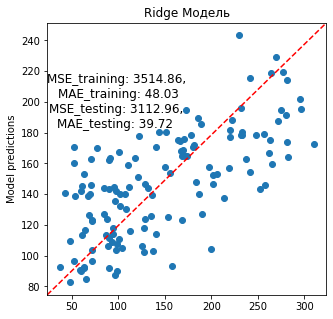

In [47]:
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import RidgeCV
model_R = Ridge()
model_R.fit(X_train, y_train)
y_pred = model_R.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
mae = median_absolute_error(y_train, y_pred)
text = f"MSE_training: {mse:.2f}, \nMAE_training: {mae:.2f}"
y_pred = model_R.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mae = median_absolute_error(y_valid, y_pred)
text += f"\nMSE_testing: {mse:.2f}, \nMAE_testing: {mae:.2f}  "
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_valid, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(100, 200, text, horizontalalignment='center',
     verticalalignment='center', fontsize=12)
plt.title("Ridge Модель")
plt.ylabel("Model predictions")

Гребневая регрессия (ридж-регрессия) – усовершенствование линейной регрессии с повышенной устойчивостью к ошибкам, налагающая ограничения на коэффициенты регрессии для получения куда более приближенного к реальности результата. Вдобавок, этот результат гораздо проще интерпретировать. Применяется метод для борьбы с переизбыточностью данных, когда независимые переменные коррелируют друг с другом (мультиколлинеарность).

#### Summary

Регуляризация — это способ уменьшить сложность модели чтобы предотвратить переобучение или исправить некорректно поставленную задачу. Обычно это достигается добавлением некоторой априорной информации к условию задачи. 
Так как метод Лассо отбрасывает не нужные параметры, а метод Ridge  более устройчив к ошибкам, по графику  Ridge видно, что линии не сближаются, а в методе Lasso наоборот.

Техника кросс-валидации (ее еще называют «скользящим контролем» или «перекрестной проверкой») предоставляет возможность найти «подходящее» значение λ по имеющимся наблюдениям. Здесь «подходящее» нужно понимать в том смысле, что мы стремимся подобрать λ, которое позволит прогнозировать значения отклика с наибольшей точностью. Очевидно, что слишком малые значения λ могут приводить к переобучению, когда модель будет подстраиваться под шум, присутствующий в исходных наблюдениях. Слишком большие λ, напротив, могут помешать определению основной закономерности. В обоих случаях будет расти ошибка, вычисленная для наблюдений, не входящих в исходную
выборку (контрольных наблюдений). Процедура кросс-валидации искусственно разделяет исходные наблюдения на контрольную и обучающую выборки.
По обучающей выборке строятся оценки регрессионных коэффициентов. Далее полученная регрессионная модель валидируется на контрольной выборке

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [52]:
make_model(degree=15, penalty='L1', alpha=0.1).fit(X, y)['reg'].coef_

array([ 20.27427799,   0.30474998, -20.89563763,   0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
         3.45527999,  -0.        ,   0.        ,  -0.59646794,
         0.        ,  -0.        ,   0.        ])

#### L2

In [53]:
make_model(degree=15, penalty='L2', alpha=0.1).fit(X, y)['reg'].coef_

array([ 24.47971714,  -0.25854799, -29.42135023,   3.30382902,
        -4.4087597 ,  -1.57019974,   7.68500756,  -2.01522608,
         8.82565401,  -0.55178865,   4.72878732,   0.48497207,
        -1.2677723 ,   0.22258931,  -7.50743983])

#### Summary

Методы Ридж и LASSO приближают к нулю оценки коэффициентов в том смысле, что уменьшается норма вектора оценок при увеличении λ.
Ридж-регрессия не обращает в нуль коэффициенты даже при больших λ.
LASSО осуществляет выбор подмножества переменных, то есть некоторые коэффициенты обращаются в нуль, что упрощает интерпретацию результатов регрессионного анализа.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

#### L1

In [50]:
make_model(degree=15, penalty='L1', alpha=0.1).fit(X, y)['reg'].coef_

array([ 20.27427799,   0.30474998, -20.89563763,   0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
         3.45527999,  -0.        ,   0.        ,  -0.59646794,
         0.        ,  -0.        ,   0.        ])

#### L2

In [51]:
make_model(degree=15, penalty='L2', alpha=0.1).fit(X, y)['reg'].coef_

array([ 24.47971714,  -0.25854799, -29.42135023,   3.30382902,
        -4.4087597 ,  -1.57019974,   7.68500756,  -2.01522608,
         8.82565401,  -0.55178865,   4.72878732,   0.48497207,
        -1.2677723 ,   0.22258931,  -7.50743983])

#### Summary



Регуляризация — это способ уменьшить сложность модели чтобы предотвратить переобучение или исправить некорректно поставленную задачу. 
Техника кросс-валидации (ее еще называют «скользящим контролем» или «перекрестной проверкой») предоставляет возможность найти «подходящее» значение λ по имеющимся наблюдениям. Здесь «подходящее» нужно понимать в том смысле, что мы стремимся подобрать λ, которое позволит прогнозировать значения отклика с наибольшей точностью. Очевидно, что слишком малые значения λ могут приводить к переобучению, когда модель будет подстраиваться под шум, присутствующий в исходных наблюдениях. Слишком большие λ, напротив, могут помешать определению основной закономерности.